In [1]:
# パッケージのimport
import random
import math
import time
import pandas as pd
import numpy as np
from PIL import Image

import torch
import torch.utils.data as data
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchvision import transforms

In [2]:
torch.manual_seed(1234)
torch.cuda.manual_seed(1234)
np.random.seed(1234)
random.seed(1234)

In [3]:
class Generator(nn.Module):
    
    def __init__(self,z_dim=20):
        super(Generator,self).__init__()
        
        self.layer1=nn.Sequential(nn.Linear(z_dim,1024),
                                 nn.BatchNorm1d(1024),
                                 nn.ReLU(inplace=True))
        
        self.layer2=nn.Sequential(nn.Linear(1024,7*7*128),
                                 nn.BatchNorm1d(7*7*128),
                                 nn.ReLU(inplace=True))
        
        self.layer3=nn.Sequential(nn.ConvTranspose2d(in_channels=128,out_channels=64,kernel_size=4,stride=2,padding=1),
                                 nn.BatchNorm2d(64),
                                 nn.ReLU(inplace=True))
        
        self.last=nn.Sequential(nn.ConvTranspose2d(in_channels=64,out_channels=1,kernel_size=4,stride=2,padding=1),
                               nn.Tanh())
        # 白黒画像なので出力チャネルは1
        
    def forward(self,z):
        out=self.layer1(z)
        out=self.layer2(out)
        
        # 転置畳み込み層に入れるためにテンソルの形を変形
        out=out.view(z.shape[0],128,7,7)
        out=self.layer3(out)
        out=self.last(out)
        
        return out

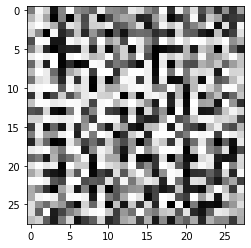

In [4]:
# 動作確認
import matplotlib.pyplot as plt
%matplotlib inline

G=Generator(z_dim=20)
G.train()

input_z=torch.randn(2,20)

fake_images=G(input_z) # 2,1,28,28
img_transformed=fake_images[0][0].detach().numpy()
plt.imshow(img_transformed,'gray')
plt.show()

In [5]:
class Discriminator(nn.Module):
    
    def __init__(self,z_dim=20):
        super(Discriminator,self).__init__()
        
        # 画像側の入力処理
        self.x_layer1=nn.Sequential(nn.Conv2d(1,64,kernel_size=4,stride=2,padding=1),
                                   nn.LeakyReLU(0.1,inplace=True))
        
        self.x_layer2=nn.Sequential(nn.Conv2d(64,64,kernel_size=4,stride=2,padding=1),
                                   nn.BatchNorm2d(64),
                                   nn.LeakyReLU(0.1,inplace=True))
        
        # 乱数側の入力処理
        self.z_layer1=nn.Linear(z_dim,512)
        
        # 最後の判定
        self.last1=nn.Sequential(nn.Linear(3648,1024),
                                nn.LeakyReLU(0.1,inplace=True))
        
        self.last2=nn.Linear(1024,1)
        
    def forward(self,x,z):
        
        x_out=self.x_layer1(x)
        x_out=self.x_layer2(x_out)
        
        z=z.view(z.shape[0],-1)
        z_out=self.z_layer1(z)
        
        # x_out,z_outを結合し全結合層で判定
        x_out=x_out.view(-1,64*7*7)
        out=torch.cat([x_out,z_out],dim=1)
        out=self.last1(out)
        
        feature=out # 最後にチャネルを1つに集約する手前の情報
        feature=feature.view(feature.size()[0],-1)
        
        out=self.last2(out)
        
        return out,feature

In [6]:
# 動作確認
D=Discriminator(z_dim=20)

# 偽画像を生成
input_z=torch.randn(2,20)
fake_images=G(input_z)

# 偽画像，乱数をDに入力
d_out,_=D(fake_images,input_z)

# 出力d_outにSigmoidをかけて0から1に変換
print(nn.Sigmoid()(d_out))

tensor([[0.4322],
        [0.4629]], grad_fn=<SigmoidBackward>)


In [7]:
class Encoder(nn.Module):
    
    def __init__(self,z_dim=20):
        super(Encoder,self).__init__()
        
        self.layer1=nn.Sequential(nn.Conv2d(1,32,kernel_size=3,stride=1), # batch,32,26,26
                                 nn.LeakyReLU(0.1,inplace=True))
        
        self.layer2=nn.Sequential(nn.Conv2d(32,64,kernel_size=3,stride=2,padding=1), # batch,64,13,13
                                 nn.BatchNorm2d(64),
                                 nn.LeakyReLU(0.1,inplace=True))
        
        self.layer3=nn.Sequential(nn.Conv2d(64,128,kernel_size=3,stride=2,padding=1), # batch,128,7,7
                                 nn.BatchNorm2d(128),
                                 nn.LeakyReLU(0.1,inplace=True))
        
        self.last=nn.Linear(128*7*7,z_dim)
        
    def forward(self,x):
        out=self.layer1(x)
        out=self.layer2(out)
        out=self.layer3(out)
        
        out=out.view(-1,128*7*7)
        out=self.last(out)
        
        return out

In [8]:
# 動作確認
E=Encoder(z_dim=20)

x=fake_images

z=E(x)
print(z)

tensor([[-0.0669, -0.2844, -0.3601,  0.1404, -0.2922, -0.4834, -0.0025,  0.0258,
         -0.1298, -0.2612, -0.4292, -0.2584, -0.6141, -0.1440,  0.1142,  0.2175,
          0.0730,  0.0323, -0.7176, -0.7410],
        [ 0.4822,  0.3682, -0.0647, -0.0773,  0.0989,  0.3012,  0.8054,  0.4398,
          1.0848, -0.2809,  0.0619, -0.3179, -0.2963, -0.1192,  0.6562, -0.1707,
          0.1287, -0.6156,  0.3127, -0.4818]], grad_fn=<AddmmBackward>)


In [9]:
# DataLoader

def make_datapath_list():
    
    train_img_list=list()
    
    for img_idx in range(200):
        img_path="./data/img_78_28size/img_7_"+str(img_idx)+'.jpg'
        train_img_list.append(img_path)
        
        img_path="./data/img_78_28size/img_8_"+str(img_idx)+'.jpg'
        train_img_list.append(img_path)
        
    return train_img_list

In [10]:
class ImageTransform():
    
    def __init__(self,mean,std):
        self.data_transform=transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean,std)
        ])
        
    def __call__(self,img):
        return self.data_transform(img)

In [11]:
class GAN_Img_Dataset(data.Dataset):
    
    def __init__(self,file_list,transform):
        self.file_list=file_list
        self.transform=transform
        
    def __len__(self):
        return len(self.file_list)
    
    def __getitem__(self,index):
        
        img_path=self.file_list[index]
        img=Image.open(img_path)
        
        img_transformed=self.transform(img)
        
        return img_transformed

In [12]:
# 動作確認

train_img_list=make_datapath_list()

mean=(0.5,)
std=(0.5,)
train_dataset=GAN_Img_Dataset(file_list=train_img_list,transform=ImageTransform(mean,std))

batch_size=64

train_dataloader=torch.utils.data.DataLoader(train_dataset,batch_size=batch_size,shuffle=True)

batch_iterator=iter(train_dataloader)
imgs=next(batch_iterator)
print(imgs.size())

torch.Size([64, 1, 28, 28])


In [19]:
# モデルを学習させる関数を作成

def train_model(G,D,E,dataloader,num_epochs):
    
    # GPU
    device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print("使用デバイス：", device)
    
    # Optimization
    lr_ge=0.0001
    lr_d=0.0001/4
    beta1,beta2=0.5,0.999
    g_optimizer=torch.optim.Adam(G.parameters(),lr_ge,[beta1,beta2])
    e_optimizer=torch.optim.Adam(E.parameters(),lr_ge,[beta1,beta2])
    d_optimizer=torch.optim.Adam(D.parameters(),lr_d,[beta1,beta2])
    
    # Loss Function
    # BCEWithLogitsLossは入力にシグモイド(logit)をかけてからバイナリークロスエントロピーを計算
    criterion=nn.BCEWithLogitsLoss(reduction="mean")
    
    # parameters
    z_dim=20
    mini_batch_size=64
    
    G.to(device)
    E.to(device)
    D.to(device)
    
    G.train()
    E.train()
    D.train()
    
    # ネットワークが固定であれば高速化させる
    torch.backends.cudnn.benchmark=True
    
    num_train_imgs=len(dataloader.dataset)
    batch_size=dataloader.batch_size
    
    iteration=1
    logs=[]
    
    for epoch in range(num_epochs):
        
        t_epoch_start=time.time()
        epoch_g_loss=0.0
        epoch_e_loss=0.0
        epoch_d_loss=0.0
        print('------------------')
        print('Epoch {}/{}'.format(epoch+1,num_epochs))
        print('------------------')
        print(' (train) ')
        
        for imgs in dataloader:
            
            if imgs.size()[0]==1: # ミニバッチサイズが1だとbatch-normでエラーになるので避ける
                continue
                
            # ミニバッチサイズの1もしくは0のラベル役のテンソルを作成．正解ラベルと偽ラベルを作成．
            # epochの最後のイテレーションはミニバッチの数が少なくなる
            mini_batch_size=imgs.size()[0]
            label_real=torch.full((mini_batch_size,),1).to(device)
            label_fake=torch.full((mini_batch_size,),0).to(device)
            
            imgs=imgs.to(device)
            
            # -------------------
            # 1. Discriminatorの学習
            # -------------------
            z_out_real=E(imgs)
            d_out_real,_=D(imgs,z_out_real)
            
            input_z=torch.randn(mini_batch_size,z_dim).to(device)
            fake_images=G(input_z)
            d_out_fake,_=D(fake_images,input_z)
            
            # calc losses
            d_loss_real=criterion(d_out_real.view(-1),label_real)
            d_loss_fake=criterion(d_out_fake.view(-1),label_fake)
            d_loss=d_loss_real+d_loss_fake
            
            d_optimizer.zero_grad()
            d_loss.backward()
            d_optimizer.step()
            
            # -------------------
            # 2. Generatorの学習
            # -------------------
            input_z=torch.randn(mini_batch_size,z_dim).to(device)
            fake_images=G(input_z)
            d_out_fake,_=D(fake_images,input_z)
            
            g_loss=criterion(d_out_fake.view(-1),label_real)
            
            g_optimizer.zero_grad()
            g_loss.backward()
            g_optimizer.step()
            
            # -------------------
            # 3. Encoderの学習
            # -------------------
            z_out_real=E(imgs)
            d_out_real,_=D(imgs,z_out_real)
            
            e_loss=criterion(d_out_real.view(-1),label_fake)
            
            e_optimizer.zero_grad()
            e_loss.backward()
            e_optimizer.step()
            
            # -------------------
            # 4. 記録
            # -------------------
            epoch_d_loss+=d_loss.item()
            epoch_g_loss+=g_loss.item()
            epoch_e_loss+=e_loss.item()
            iteration+=1
            
        # epochごとのphaseごとのlossと正解率
        t_epoch_finishi=time.time()
        print('------------------')
        print('epoch {} || Epoch__D_Loss:{:.4f} || Epoch_G_Loss:{:.4f} || Epoch_E_Loss:{:.4f}'.format(
            epoch+1,epoch_d_loss/batch_size,epoch_g_loss/batch_size,epoch_e_loss/batch_size))
        print('timer: {:.4f} sec.'.format(t_epoch_finishi-t_epoch_start))
        t_epoch_start=time.time()
        
    print("総イテレーション回数：",iteration)
    
    return G,D,E

In [20]:
def weights_init(m):
    classname=m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data,0.0,0.02)
        nn.init.constant_(m.bias.data,0)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data,0.0,0.02)
        nn.init.constant_(m.bias.data,0)
    elif classname.find('Linear') != -1:
        m.bias.data.fill_(0)
        
# 初期化の実施
G.apply(weights_init)
E.apply(weights_init)
D.apply(weights_init)

print('ネットワークの初期化完了')

ネットワークの初期化完了


In [21]:
# 学習・検証
num_epochs=1500
G_update,D_update,E_update=train_model(G,D,E,dataloader=train_dataloader,num_epochs=num_epochs)

使用デバイス： cuda:0
------------------
Epoch 1/1500
------------------
 (train) 
------------------
epoch 1 || Epoch__D_Loss:0.1481 || Epoch_G_Loss:0.0788 || Epoch_E_Loss:0.0766
timer: 1.1351 sec.
------------------
Epoch 2/1500
------------------
 (train) 
------------------
epoch 2 || Epoch__D_Loss:0.1445 || Epoch_G_Loss:0.0815 || Epoch_E_Loss:0.0781
timer: 0.5745 sec.
------------------
Epoch 3/1500
------------------
 (train) 
------------------
epoch 3 || Epoch__D_Loss:0.1408 || Epoch_G_Loss:0.0836 || Epoch_E_Loss:0.0804
timer: 0.4886 sec.
------------------
Epoch 4/1500
------------------
 (train) 
------------------
epoch 4 || Epoch__D_Loss:0.1366 || Epoch_G_Loss:0.0852 || Epoch_E_Loss:0.0834
timer: 0.4520 sec.
------------------
Epoch 5/1500
------------------
 (train) 
------------------
epoch 5 || Epoch__D_Loss:0.1330 || Epoch_G_Loss:0.0870 || Epoch_E_Loss:0.0856
timer: 0.4631 sec.
------------------
Epoch 6/1500
------------------
 (train) 
------------------
epoch 6 || Epoch__D_

------------------
epoch 47 || Epoch__D_Loss:0.0112 || Epoch_G_Loss:0.3374 || Epoch_E_Loss:0.3577
timer: 0.4601 sec.
------------------
Epoch 48/1500
------------------
 (train) 
------------------
epoch 48 || Epoch__D_Loss:0.0107 || Epoch_G_Loss:0.3463 || Epoch_E_Loss:0.3652
timer: 0.4534 sec.
------------------
Epoch 49/1500
------------------
 (train) 
------------------
epoch 49 || Epoch__D_Loss:0.0105 || Epoch_G_Loss:0.3524 || Epoch_E_Loss:0.3635
timer: 0.4642 sec.
------------------
Epoch 50/1500
------------------
 (train) 
------------------
epoch 50 || Epoch__D_Loss:0.0118 || Epoch_G_Loss:0.3571 || Epoch_E_Loss:0.3431
timer: 0.4633 sec.
------------------
Epoch 51/1500
------------------
 (train) 
------------------
epoch 51 || Epoch__D_Loss:0.0104 || Epoch_G_Loss:0.3708 || Epoch_E_Loss:0.3706
timer: 0.4615 sec.
------------------
Epoch 52/1500
------------------
 (train) 
------------------
epoch 52 || Epoch__D_Loss:0.0072 || Epoch_G_Loss:0.3808 || Epoch_E_Loss:0.4223
timer: 

------------------
epoch 93 || Epoch__D_Loss:0.0304 || Epoch_G_Loss:0.3034 || Epoch_E_Loss:0.3105
timer: 0.4639 sec.
------------------
Epoch 94/1500
------------------
 (train) 
------------------
epoch 94 || Epoch__D_Loss:0.0291 || Epoch_G_Loss:0.3217 || Epoch_E_Loss:0.3049
timer: 0.4629 sec.
------------------
Epoch 95/1500
------------------
 (train) 
------------------
epoch 95 || Epoch__D_Loss:0.0300 || Epoch_G_Loss:0.2930 || Epoch_E_Loss:0.3102
timer: 0.4522 sec.
------------------
Epoch 96/1500
------------------
 (train) 
------------------
epoch 96 || Epoch__D_Loss:0.0322 || Epoch_G_Loss:0.2996 || Epoch_E_Loss:0.2972
timer: 0.4667 sec.
------------------
Epoch 97/1500
------------------
 (train) 
------------------
epoch 97 || Epoch__D_Loss:0.0318 || Epoch_G_Loss:0.3050 || Epoch_E_Loss:0.3005
timer: 0.4566 sec.
------------------
Epoch 98/1500
------------------
 (train) 
------------------
epoch 98 || Epoch__D_Loss:0.0297 || Epoch_G_Loss:0.3021 || Epoch_E_Loss:0.3045
timer: 

------------------
epoch 139 || Epoch__D_Loss:0.0898 || Epoch_G_Loss:0.1660 || Epoch_E_Loss:0.2066
timer: 0.4666 sec.
------------------
Epoch 140/1500
------------------
 (train) 
------------------
epoch 140 || Epoch__D_Loss:0.1126 || Epoch_G_Loss:0.1802 || Epoch_E_Loss:0.1736
timer: 0.4684 sec.
------------------
Epoch 141/1500
------------------
 (train) 
------------------
epoch 141 || Epoch__D_Loss:0.0895 || Epoch_G_Loss:0.1771 || Epoch_E_Loss:0.2122
timer: 0.4711 sec.
------------------
Epoch 142/1500
------------------
 (train) 
------------------
epoch 142 || Epoch__D_Loss:0.0735 || Epoch_G_Loss:0.1871 || Epoch_E_Loss:0.2288
timer: 0.4739 sec.
------------------
Epoch 143/1500
------------------
 (train) 
------------------
epoch 143 || Epoch__D_Loss:0.0862 || Epoch_G_Loss:0.1773 || Epoch_E_Loss:0.2092
timer: 0.4620 sec.
------------------
Epoch 144/1500
------------------
 (train) 
------------------
epoch 144 || Epoch__D_Loss:0.1046 || Epoch_G_Loss:0.1487 || Epoch_E_Loss:0.1

------------------
epoch 185 || Epoch__D_Loss:0.1265 || Epoch_G_Loss:0.1423 || Epoch_E_Loss:0.1495
timer: 0.4662 sec.
------------------
Epoch 186/1500
------------------
 (train) 
------------------
epoch 186 || Epoch__D_Loss:0.1150 || Epoch_G_Loss:0.1532 || Epoch_E_Loss:0.1491
timer: 0.4681 sec.
------------------
Epoch 187/1500
------------------
 (train) 
------------------
epoch 187 || Epoch__D_Loss:0.1168 || Epoch_G_Loss:0.1404 || Epoch_E_Loss:0.1522
timer: 0.4638 sec.
------------------
Epoch 188/1500
------------------
 (train) 
------------------
epoch 188 || Epoch__D_Loss:0.1241 || Epoch_G_Loss:0.1341 || Epoch_E_Loss:0.1477
timer: 0.4571 sec.
------------------
Epoch 189/1500
------------------
 (train) 
------------------
epoch 189 || Epoch__D_Loss:0.1318 || Epoch_G_Loss:0.1424 || Epoch_E_Loss:0.1418
timer: 0.4708 sec.
------------------
Epoch 190/1500
------------------
 (train) 
------------------
epoch 190 || Epoch__D_Loss:0.1205 || Epoch_G_Loss:0.1364 || Epoch_E_Loss:0.1

------------------
epoch 231 || Epoch__D_Loss:0.1058 || Epoch_G_Loss:0.1392 || Epoch_E_Loss:0.1477
timer: 0.4605 sec.
------------------
Epoch 232/1500
------------------
 (train) 
------------------
epoch 232 || Epoch__D_Loss:0.1072 || Epoch_G_Loss:0.1418 || Epoch_E_Loss:0.1459
timer: 0.4675 sec.
------------------
Epoch 233/1500
------------------
 (train) 
------------------
epoch 233 || Epoch__D_Loss:0.1037 || Epoch_G_Loss:0.1498 || Epoch_E_Loss:0.1446
timer: 0.4635 sec.
------------------
Epoch 234/1500
------------------
 (train) 
------------------
epoch 234 || Epoch__D_Loss:0.1017 || Epoch_G_Loss:0.1411 || Epoch_E_Loss:0.1490
timer: 0.4516 sec.
------------------
Epoch 235/1500
------------------
 (train) 
------------------
epoch 235 || Epoch__D_Loss:0.1203 || Epoch_G_Loss:0.1286 || Epoch_E_Loss:0.1358
timer: 0.4610 sec.
------------------
Epoch 236/1500
------------------
 (train) 
------------------
epoch 236 || Epoch__D_Loss:0.1309 || Epoch_G_Loss:0.1209 || Epoch_E_Loss:0.1

------------------
epoch 277 || Epoch__D_Loss:0.1337 || Epoch_G_Loss:0.1032 || Epoch_E_Loss:0.1246
timer: 0.4569 sec.
------------------
Epoch 278/1500
------------------
 (train) 
------------------
epoch 278 || Epoch__D_Loss:0.1499 || Epoch_G_Loss:0.1056 || Epoch_E_Loss:0.1138
timer: 0.4660 sec.
------------------
Epoch 279/1500
------------------
 (train) 
------------------
epoch 279 || Epoch__D_Loss:0.1601 || Epoch_G_Loss:0.0960 || Epoch_E_Loss:0.1059
timer: 0.4568 sec.
------------------
Epoch 280/1500
------------------
 (train) 
------------------
epoch 280 || Epoch__D_Loss:0.1592 || Epoch_G_Loss:0.1018 || Epoch_E_Loss:0.1072
timer: 0.4613 sec.
------------------
Epoch 281/1500
------------------
 (train) 
------------------
epoch 281 || Epoch__D_Loss:0.1438 || Epoch_G_Loss:0.1154 || Epoch_E_Loss:0.1124
timer: 0.4693 sec.
------------------
Epoch 282/1500
------------------
 (train) 
------------------
epoch 282 || Epoch__D_Loss:0.1250 || Epoch_G_Loss:0.1112 || Epoch_E_Loss:0.1

------------------
epoch 323 || Epoch__D_Loss:0.1964 || Epoch_G_Loss:0.0810 || Epoch_E_Loss:0.0960
timer: 0.4608 sec.
------------------
Epoch 324/1500
------------------
 (train) 
------------------
epoch 324 || Epoch__D_Loss:0.1836 || Epoch_G_Loss:0.0886 || Epoch_E_Loss:0.1011
timer: 0.4617 sec.
------------------
Epoch 325/1500
------------------
 (train) 
------------------
epoch 325 || Epoch__D_Loss:0.1476 || Epoch_G_Loss:0.1108 || Epoch_E_Loss:0.1213
timer: 0.4615 sec.
------------------
Epoch 326/1500
------------------
 (train) 
------------------
epoch 326 || Epoch__D_Loss:0.1420 || Epoch_G_Loss:0.0986 || Epoch_E_Loss:0.1260
timer: 0.4592 sec.
------------------
Epoch 327/1500
------------------
 (train) 
------------------
epoch 327 || Epoch__D_Loss:0.1587 || Epoch_G_Loss:0.0836 || Epoch_E_Loss:0.1194
timer: 0.4633 sec.
------------------
Epoch 328/1500
------------------
 (train) 
------------------
epoch 328 || Epoch__D_Loss:0.1532 || Epoch_G_Loss:0.0892 || Epoch_E_Loss:0.1

------------------
epoch 369 || Epoch__D_Loss:0.1629 || Epoch_G_Loss:0.1015 || Epoch_E_Loss:0.1145
timer: 0.4684 sec.
------------------
Epoch 370/1500
------------------
 (train) 
------------------
epoch 370 || Epoch__D_Loss:0.1564 || Epoch_G_Loss:0.0948 || Epoch_E_Loss:0.1151
timer: 0.4594 sec.
------------------
Epoch 371/1500
------------------
 (train) 
------------------
epoch 371 || Epoch__D_Loss:0.1704 || Epoch_G_Loss:0.0903 || Epoch_E_Loss:0.1071
timer: 0.4651 sec.
------------------
Epoch 372/1500
------------------
 (train) 
------------------
epoch 372 || Epoch__D_Loss:0.2134 || Epoch_G_Loss:0.0691 || Epoch_E_Loss:0.0856
timer: 0.4643 sec.
------------------
Epoch 373/1500
------------------
 (train) 
------------------
epoch 373 || Epoch__D_Loss:0.1961 || Epoch_G_Loss:0.0775 || Epoch_E_Loss:0.0911
timer: 0.4558 sec.
------------------
Epoch 374/1500
------------------
 (train) 
------------------
epoch 374 || Epoch__D_Loss:0.1843 || Epoch_G_Loss:0.0762 || Epoch_E_Loss:0.0

------------------
epoch 415 || Epoch__D_Loss:0.1713 || Epoch_G_Loss:0.0843 || Epoch_E_Loss:0.1014
timer: 0.4664 sec.
------------------
Epoch 416/1500
------------------
 (train) 
------------------
epoch 416 || Epoch__D_Loss:0.1391 || Epoch_G_Loss:0.0999 || Epoch_E_Loss:0.1191
timer: 0.4541 sec.
------------------
Epoch 417/1500
------------------
 (train) 
------------------
epoch 417 || Epoch__D_Loss:0.1411 || Epoch_G_Loss:0.1104 || Epoch_E_Loss:0.1162
timer: 0.4555 sec.
------------------
Epoch 418/1500
------------------
 (train) 
------------------
epoch 418 || Epoch__D_Loss:0.1468 || Epoch_G_Loss:0.1007 || Epoch_E_Loss:0.1144
timer: 0.4548 sec.
------------------
Epoch 419/1500
------------------
 (train) 
------------------
epoch 419 || Epoch__D_Loss:0.1493 || Epoch_G_Loss:0.0991 || Epoch_E_Loss:0.1141
timer: 0.4560 sec.
------------------
Epoch 420/1500
------------------
 (train) 
------------------
epoch 420 || Epoch__D_Loss:0.1524 || Epoch_G_Loss:0.0944 || Epoch_E_Loss:0.1

------------------
epoch 461 || Epoch__D_Loss:0.1425 || Epoch_G_Loss:0.0932 || Epoch_E_Loss:0.1138
timer: 0.4645 sec.
------------------
Epoch 462/1500
------------------
 (train) 
------------------
epoch 462 || Epoch__D_Loss:0.1402 || Epoch_G_Loss:0.0965 || Epoch_E_Loss:0.1143
timer: 0.4565 sec.
------------------
Epoch 463/1500
------------------
 (train) 
------------------
epoch 463 || Epoch__D_Loss:0.1413 || Epoch_G_Loss:0.0966 || Epoch_E_Loss:0.1105
timer: 0.4556 sec.
------------------
Epoch 464/1500
------------------
 (train) 
------------------
epoch 464 || Epoch__D_Loss:0.1519 || Epoch_G_Loss:0.0883 || Epoch_E_Loss:0.1033
timer: 0.4705 sec.
------------------
Epoch 465/1500
------------------
 (train) 
------------------
epoch 465 || Epoch__D_Loss:0.1644 || Epoch_G_Loss:0.0777 || Epoch_E_Loss:0.1008
timer: 0.4674 sec.
------------------
Epoch 466/1500
------------------
 (train) 
------------------
epoch 466 || Epoch__D_Loss:0.1795 || Epoch_G_Loss:0.0764 || Epoch_E_Loss:0.0

------------------
epoch 507 || Epoch__D_Loss:0.1425 || Epoch_G_Loss:0.0904 || Epoch_E_Loss:0.1028
timer: 0.4645 sec.
------------------
Epoch 508/1500
------------------
 (train) 
------------------
epoch 508 || Epoch__D_Loss:0.1203 || Epoch_G_Loss:0.1027 || Epoch_E_Loss:0.1153
timer: 0.4601 sec.
------------------
Epoch 509/1500
------------------
 (train) 
------------------
epoch 509 || Epoch__D_Loss:0.1106 || Epoch_G_Loss:0.1164 || Epoch_E_Loss:0.1233
timer: 0.4641 sec.
------------------
Epoch 510/1500
------------------
 (train) 
------------------
epoch 510 || Epoch__D_Loss:0.1134 || Epoch_G_Loss:0.1051 || Epoch_E_Loss:0.1251
timer: 0.4630 sec.
------------------
Epoch 511/1500
------------------
 (train) 
------------------
epoch 511 || Epoch__D_Loss:0.1323 || Epoch_G_Loss:0.0944 || Epoch_E_Loss:0.1095
timer: 0.4655 sec.
------------------
Epoch 512/1500
------------------
 (train) 
------------------
epoch 512 || Epoch__D_Loss:0.1680 || Epoch_G_Loss:0.0814 || Epoch_E_Loss:0.0

------------------
epoch 553 || Epoch__D_Loss:0.1285 || Epoch_G_Loss:0.1093 || Epoch_E_Loss:0.1083
timer: 0.4687 sec.
------------------
Epoch 554/1500
------------------
 (train) 
------------------
epoch 554 || Epoch__D_Loss:0.1412 || Epoch_G_Loss:0.1022 || Epoch_E_Loss:0.1016
timer: 0.4551 sec.
------------------
Epoch 555/1500
------------------
 (train) 
------------------
epoch 555 || Epoch__D_Loss:0.1418 || Epoch_G_Loss:0.0977 || Epoch_E_Loss:0.1026
timer: 0.4620 sec.
------------------
Epoch 556/1500
------------------
 (train) 
------------------
epoch 556 || Epoch__D_Loss:0.1285 || Epoch_G_Loss:0.1019 || Epoch_E_Loss:0.1085
timer: 0.4760 sec.
------------------
Epoch 557/1500
------------------
 (train) 
------------------
epoch 557 || Epoch__D_Loss:0.1249 || Epoch_G_Loss:0.0940 || Epoch_E_Loss:0.1158
timer: 0.4764 sec.
------------------
Epoch 558/1500
------------------
 (train) 
------------------
epoch 558 || Epoch__D_Loss:0.1294 || Epoch_G_Loss:0.0967 || Epoch_E_Loss:0.1

------------------
epoch 599 || Epoch__D_Loss:0.1429 || Epoch_G_Loss:0.0917 || Epoch_E_Loss:0.1014
timer: 0.4655 sec.
------------------
Epoch 600/1500
------------------
 (train) 
------------------
epoch 600 || Epoch__D_Loss:0.1560 || Epoch_G_Loss:0.0874 || Epoch_E_Loss:0.0933
timer: 0.4672 sec.
------------------
Epoch 601/1500
------------------
 (train) 
------------------
epoch 601 || Epoch__D_Loss:0.1530 || Epoch_G_Loss:0.0888 || Epoch_E_Loss:0.0951
timer: 0.4589 sec.
------------------
Epoch 602/1500
------------------
 (train) 
------------------
epoch 602 || Epoch__D_Loss:0.1487 || Epoch_G_Loss:0.0927 || Epoch_E_Loss:0.0973
timer: 0.4582 sec.
------------------
Epoch 603/1500
------------------
 (train) 
------------------
epoch 603 || Epoch__D_Loss:0.1459 || Epoch_G_Loss:0.0937 || Epoch_E_Loss:0.1022
timer: 0.4615 sec.
------------------
Epoch 604/1500
------------------
 (train) 
------------------
epoch 604 || Epoch__D_Loss:0.1352 || Epoch_G_Loss:0.1090 || Epoch_E_Loss:0.1

------------------
epoch 645 || Epoch__D_Loss:0.1153 || Epoch_G_Loss:0.1073 || Epoch_E_Loss:0.1161
timer: 0.4555 sec.
------------------
Epoch 646/1500
------------------
 (train) 
------------------
epoch 646 || Epoch__D_Loss:0.1155 || Epoch_G_Loss:0.1049 || Epoch_E_Loss:0.1228
timer: 0.4632 sec.
------------------
Epoch 647/1500
------------------
 (train) 
------------------
epoch 647 || Epoch__D_Loss:0.1154 || Epoch_G_Loss:0.1150 || Epoch_E_Loss:0.1175
timer: 0.4635 sec.
------------------
Epoch 648/1500
------------------
 (train) 
------------------
epoch 648 || Epoch__D_Loss:0.1228 || Epoch_G_Loss:0.1027 || Epoch_E_Loss:0.1116
timer: 0.4541 sec.
------------------
Epoch 649/1500
------------------
 (train) 
------------------
epoch 649 || Epoch__D_Loss:0.1364 || Epoch_G_Loss:0.0979 || Epoch_E_Loss:0.1028
timer: 0.4614 sec.
------------------
Epoch 650/1500
------------------
 (train) 
------------------
epoch 650 || Epoch__D_Loss:0.1456 || Epoch_G_Loss:0.0921 || Epoch_E_Loss:0.0

------------------
epoch 691 || Epoch__D_Loss:0.1331 || Epoch_G_Loss:0.0936 || Epoch_E_Loss:0.1062
timer: 0.4627 sec.
------------------
Epoch 692/1500
------------------
 (train) 
------------------
epoch 692 || Epoch__D_Loss:0.1345 || Epoch_G_Loss:0.0927 || Epoch_E_Loss:0.1058
timer: 0.4593 sec.
------------------
Epoch 693/1500
------------------
 (train) 
------------------
epoch 693 || Epoch__D_Loss:0.1343 || Epoch_G_Loss:0.0915 || Epoch_E_Loss:0.1071
timer: 0.4753 sec.
------------------
Epoch 694/1500
------------------
 (train) 
------------------
epoch 694 || Epoch__D_Loss:0.1314 || Epoch_G_Loss:0.0967 || Epoch_E_Loss:0.1086
timer: 0.4544 sec.
------------------
Epoch 695/1500
------------------
 (train) 
------------------
epoch 695 || Epoch__D_Loss:0.1361 || Epoch_G_Loss:0.1032 || Epoch_E_Loss:0.1060
timer: 0.4623 sec.
------------------
Epoch 696/1500
------------------
 (train) 
------------------
epoch 696 || Epoch__D_Loss:0.1272 || Epoch_G_Loss:0.0955 || Epoch_E_Loss:0.1

------------------
epoch 737 || Epoch__D_Loss:0.1521 || Epoch_G_Loss:0.0891 || Epoch_E_Loss:0.1019
timer: 0.4542 sec.
------------------
Epoch 738/1500
------------------
 (train) 
------------------
epoch 738 || Epoch__D_Loss:0.1389 || Epoch_G_Loss:0.0937 || Epoch_E_Loss:0.1071
timer: 0.4638 sec.
------------------
Epoch 739/1500
------------------
 (train) 
------------------
epoch 739 || Epoch__D_Loss:0.1169 || Epoch_G_Loss:0.1100 || Epoch_E_Loss:0.1206
timer: 0.4610 sec.
------------------
Epoch 740/1500
------------------
 (train) 
------------------
epoch 740 || Epoch__D_Loss:0.1159 || Epoch_G_Loss:0.1239 || Epoch_E_Loss:0.1217
timer: 0.4655 sec.
------------------
Epoch 741/1500
------------------
 (train) 
------------------
epoch 741 || Epoch__D_Loss:0.1145 || Epoch_G_Loss:0.1194 || Epoch_E_Loss:0.1264
timer: 0.4589 sec.
------------------
Epoch 742/1500
------------------
 (train) 
------------------
epoch 742 || Epoch__D_Loss:0.1185 || Epoch_G_Loss:0.1083 || Epoch_E_Loss:0.1

------------------
epoch 783 || Epoch__D_Loss:0.1235 || Epoch_G_Loss:0.1089 || Epoch_E_Loss:0.1150
timer: 0.4565 sec.
------------------
Epoch 784/1500
------------------
 (train) 
------------------
epoch 784 || Epoch__D_Loss:0.1079 || Epoch_G_Loss:0.1258 || Epoch_E_Loss:0.1236
timer: 0.4610 sec.
------------------
Epoch 785/1500
------------------
 (train) 
------------------
epoch 785 || Epoch__D_Loss:0.1006 || Epoch_G_Loss:0.1212 || Epoch_E_Loss:0.1366
timer: 0.4689 sec.
------------------
Epoch 786/1500
------------------
 (train) 
------------------
epoch 786 || Epoch__D_Loss:0.0984 || Epoch_G_Loss:0.1407 || Epoch_E_Loss:0.1288
timer: 0.4557 sec.
------------------
Epoch 787/1500
------------------
 (train) 
------------------
epoch 787 || Epoch__D_Loss:0.1106 || Epoch_G_Loss:0.1149 || Epoch_E_Loss:0.1369
timer: 0.4688 sec.
------------------
Epoch 788/1500
------------------
 (train) 
------------------
epoch 788 || Epoch__D_Loss:0.1189 || Epoch_G_Loss:0.1139 || Epoch_E_Loss:0.1

------------------
epoch 829 || Epoch__D_Loss:0.1437 || Epoch_G_Loss:0.1068 || Epoch_E_Loss:0.0940
timer: 0.4694 sec.
------------------
Epoch 830/1500
------------------
 (train) 
------------------
epoch 830 || Epoch__D_Loss:0.1320 || Epoch_G_Loss:0.0998 || Epoch_E_Loss:0.1058
timer: 0.4570 sec.
------------------
Epoch 831/1500
------------------
 (train) 
------------------
epoch 831 || Epoch__D_Loss:0.1199 || Epoch_G_Loss:0.1056 || Epoch_E_Loss:0.1175
timer: 0.4641 sec.
------------------
Epoch 832/1500
------------------
 (train) 
------------------
epoch 832 || Epoch__D_Loss:0.1043 || Epoch_G_Loss:0.1209 || Epoch_E_Loss:0.1233
timer: 0.4502 sec.
------------------
Epoch 833/1500
------------------
 (train) 
------------------
epoch 833 || Epoch__D_Loss:0.0994 || Epoch_G_Loss:0.1238 || Epoch_E_Loss:0.1314
timer: 0.4603 sec.
------------------
Epoch 834/1500
------------------
 (train) 
------------------
epoch 834 || Epoch__D_Loss:0.1116 || Epoch_G_Loss:0.1221 || Epoch_E_Loss:0.1

------------------
epoch 875 || Epoch__D_Loss:0.1265 || Epoch_G_Loss:0.1063 || Epoch_E_Loss:0.1147
timer: 0.4659 sec.
------------------
Epoch 876/1500
------------------
 (train) 
------------------
epoch 876 || Epoch__D_Loss:0.1257 || Epoch_G_Loss:0.1077 || Epoch_E_Loss:0.1087
timer: 0.4581 sec.
------------------
Epoch 877/1500
------------------
 (train) 
------------------
epoch 877 || Epoch__D_Loss:0.1301 || Epoch_G_Loss:0.0996 || Epoch_E_Loss:0.1120
timer: 0.4647 sec.
------------------
Epoch 878/1500
------------------
 (train) 
------------------
epoch 878 || Epoch__D_Loss:0.1292 || Epoch_G_Loss:0.1082 || Epoch_E_Loss:0.1087
timer: 0.4564 sec.
------------------
Epoch 879/1500
------------------
 (train) 
------------------
epoch 879 || Epoch__D_Loss:0.1275 || Epoch_G_Loss:0.1067 || Epoch_E_Loss:0.1132
timer: 0.4596 sec.
------------------
Epoch 880/1500
------------------
 (train) 
------------------
epoch 880 || Epoch__D_Loss:0.1257 || Epoch_G_Loss:0.1066 || Epoch_E_Loss:0.1

------------------
epoch 921 || Epoch__D_Loss:0.1202 || Epoch_G_Loss:0.1235 || Epoch_E_Loss:0.1189
timer: 0.4664 sec.
------------------
Epoch 922/1500
------------------
 (train) 
------------------
epoch 922 || Epoch__D_Loss:0.1205 || Epoch_G_Loss:0.1108 || Epoch_E_Loss:0.1274
timer: 0.4568 sec.
------------------
Epoch 923/1500
------------------
 (train) 
------------------
epoch 923 || Epoch__D_Loss:0.1142 || Epoch_G_Loss:0.1189 || Epoch_E_Loss:0.1194
timer: 0.4669 sec.
------------------
Epoch 924/1500
------------------
 (train) 
------------------
epoch 924 || Epoch__D_Loss:0.1138 || Epoch_G_Loss:0.1178 || Epoch_E_Loss:0.1238
timer: 0.4700 sec.
------------------
Epoch 925/1500
------------------
 (train) 
------------------
epoch 925 || Epoch__D_Loss:0.1148 || Epoch_G_Loss:0.1198 || Epoch_E_Loss:0.1252
timer: 0.4632 sec.
------------------
Epoch 926/1500
------------------
 (train) 
------------------
epoch 926 || Epoch__D_Loss:0.1169 || Epoch_G_Loss:0.1215 || Epoch_E_Loss:0.1

------------------
epoch 967 || Epoch__D_Loss:0.1090 || Epoch_G_Loss:0.1196 || Epoch_E_Loss:0.1312
timer: 0.4682 sec.
------------------
Epoch 968/1500
------------------
 (train) 
------------------
epoch 968 || Epoch__D_Loss:0.1152 || Epoch_G_Loss:0.1140 || Epoch_E_Loss:0.1214
timer: 0.4725 sec.
------------------
Epoch 969/1500
------------------
 (train) 
------------------
epoch 969 || Epoch__D_Loss:0.1196 || Epoch_G_Loss:0.1087 || Epoch_E_Loss:0.1205
timer: 0.4621 sec.
------------------
Epoch 970/1500
------------------
 (train) 
------------------
epoch 970 || Epoch__D_Loss:0.1272 || Epoch_G_Loss:0.1103 || Epoch_E_Loss:0.1157
timer: 0.4532 sec.
------------------
Epoch 971/1500
------------------
 (train) 
------------------
epoch 971 || Epoch__D_Loss:0.1186 || Epoch_G_Loss:0.1116 || Epoch_E_Loss:0.1238
timer: 0.4547 sec.
------------------
Epoch 972/1500
------------------
 (train) 
------------------
epoch 972 || Epoch__D_Loss:0.1166 || Epoch_G_Loss:0.1207 || Epoch_E_Loss:0.1

------------------
epoch 1013 || Epoch__D_Loss:0.1121 || Epoch_G_Loss:0.1201 || Epoch_E_Loss:0.1200
timer: 0.4726 sec.
------------------
Epoch 1014/1500
------------------
 (train) 
------------------
epoch 1014 || Epoch__D_Loss:0.1103 || Epoch_G_Loss:0.1123 || Epoch_E_Loss:0.1184
timer: 0.4508 sec.
------------------
Epoch 1015/1500
------------------
 (train) 
------------------
epoch 1015 || Epoch__D_Loss:0.1167 || Epoch_G_Loss:0.1099 || Epoch_E_Loss:0.1163
timer: 0.4728 sec.
------------------
Epoch 1016/1500
------------------
 (train) 
------------------
epoch 1016 || Epoch__D_Loss:0.1145 || Epoch_G_Loss:0.1065 || Epoch_E_Loss:0.1224
timer: 0.4516 sec.
------------------
Epoch 1017/1500
------------------
 (train) 
------------------
epoch 1017 || Epoch__D_Loss:0.1128 || Epoch_G_Loss:0.1163 || Epoch_E_Loss:0.1208
timer: 0.4680 sec.
------------------
Epoch 1018/1500
------------------
 (train) 
------------------
epoch 1018 || Epoch__D_Loss:0.1032 || Epoch_G_Loss:0.1167 || Epoch

------------------
epoch 1058 || Epoch__D_Loss:0.1077 || Epoch_G_Loss:0.1160 || Epoch_E_Loss:0.1329
timer: 0.4815 sec.
------------------
Epoch 1059/1500
------------------
 (train) 
------------------
epoch 1059 || Epoch__D_Loss:0.1140 || Epoch_G_Loss:0.1246 || Epoch_E_Loss:0.1203
timer: 0.4656 sec.
------------------
Epoch 1060/1500
------------------
 (train) 
------------------
epoch 1060 || Epoch__D_Loss:0.1115 || Epoch_G_Loss:0.1225 || Epoch_E_Loss:0.1193
timer: 0.4733 sec.
------------------
Epoch 1061/1500
------------------
 (train) 
------------------
epoch 1061 || Epoch__D_Loss:0.1078 || Epoch_G_Loss:0.1136 || Epoch_E_Loss:0.1265
timer: 0.4637 sec.
------------------
Epoch 1062/1500
------------------
 (train) 
------------------
epoch 1062 || Epoch__D_Loss:0.1135 || Epoch_G_Loss:0.1157 || Epoch_E_Loss:0.1206
timer: 0.4661 sec.
------------------
Epoch 1063/1500
------------------
 (train) 
------------------
epoch 1063 || Epoch__D_Loss:0.1161 || Epoch_G_Loss:0.1081 || Epoch

------------------
epoch 1103 || Epoch__D_Loss:0.1168 || Epoch_G_Loss:0.1318 || Epoch_E_Loss:0.1591
timer: 0.4669 sec.
------------------
Epoch 1104/1500
------------------
 (train) 
------------------
epoch 1104 || Epoch__D_Loss:0.1250 || Epoch_G_Loss:0.1312 || Epoch_E_Loss:0.1413
timer: 0.4575 sec.
------------------
Epoch 1105/1500
------------------
 (train) 
------------------
epoch 1105 || Epoch__D_Loss:0.1457 || Epoch_G_Loss:0.1070 || Epoch_E_Loss:0.1311
timer: 0.4655 sec.
------------------
Epoch 1106/1500
------------------
 (train) 
------------------
epoch 1106 || Epoch__D_Loss:0.1434 || Epoch_G_Loss:0.1044 || Epoch_E_Loss:0.1323
timer: 0.4843 sec.
------------------
Epoch 1107/1500
------------------
 (train) 
------------------
epoch 1107 || Epoch__D_Loss:0.1222 || Epoch_G_Loss:0.1249 || Epoch_E_Loss:0.1415
timer: 0.4746 sec.
------------------
Epoch 1108/1500
------------------
 (train) 
------------------
epoch 1108 || Epoch__D_Loss:0.1157 || Epoch_G_Loss:0.1257 || Epoch

------------------
epoch 1148 || Epoch__D_Loss:0.1118 || Epoch_G_Loss:0.1322 || Epoch_E_Loss:0.1236
timer: 0.4679 sec.
------------------
Epoch 1149/1500
------------------
 (train) 
------------------
epoch 1149 || Epoch__D_Loss:0.1316 || Epoch_G_Loss:0.1034 || Epoch_E_Loss:0.1234
timer: 0.4690 sec.
------------------
Epoch 1150/1500
------------------
 (train) 
------------------
epoch 1150 || Epoch__D_Loss:0.1235 || Epoch_G_Loss:0.1087 || Epoch_E_Loss:0.1165
timer: 0.4642 sec.
------------------
Epoch 1151/1500
------------------
 (train) 
------------------
epoch 1151 || Epoch__D_Loss:0.1088 || Epoch_G_Loss:0.1217 || Epoch_E_Loss:0.1401
timer: 0.4573 sec.
------------------
Epoch 1152/1500
------------------
 (train) 
------------------
epoch 1152 || Epoch__D_Loss:0.0892 || Epoch_G_Loss:0.1370 || Epoch_E_Loss:0.1477
timer: 0.4686 sec.
------------------
Epoch 1153/1500
------------------
 (train) 
------------------
epoch 1153 || Epoch__D_Loss:0.1088 || Epoch_G_Loss:0.1106 || Epoch

------------------
epoch 1193 || Epoch__D_Loss:0.1182 || Epoch_G_Loss:0.1211 || Epoch_E_Loss:0.1410
timer: 0.4661 sec.
------------------
Epoch 1194/1500
------------------
 (train) 
------------------
epoch 1194 || Epoch__D_Loss:0.1115 || Epoch_G_Loss:0.1340 || Epoch_E_Loss:0.1324
timer: 0.4633 sec.
------------------
Epoch 1195/1500
------------------
 (train) 
------------------
epoch 1195 || Epoch__D_Loss:0.0981 || Epoch_G_Loss:0.1349 || Epoch_E_Loss:0.1389
timer: 0.4596 sec.
------------------
Epoch 1196/1500
------------------
 (train) 
------------------
epoch 1196 || Epoch__D_Loss:0.0916 || Epoch_G_Loss:0.1382 || Epoch_E_Loss:0.1485
timer: 0.4585 sec.
------------------
Epoch 1197/1500
------------------
 (train) 
------------------
epoch 1197 || Epoch__D_Loss:0.0976 || Epoch_G_Loss:0.1334 || Epoch_E_Loss:0.1370
timer: 0.4552 sec.
------------------
Epoch 1198/1500
------------------
 (train) 
------------------
epoch 1198 || Epoch__D_Loss:0.1057 || Epoch_G_Loss:0.1220 || Epoch

------------------
epoch 1238 || Epoch__D_Loss:0.1084 || Epoch_G_Loss:0.1255 || Epoch_E_Loss:0.1329
timer: 0.4639 sec.
------------------
Epoch 1239/1500
------------------
 (train) 
------------------
epoch 1239 || Epoch__D_Loss:0.1184 || Epoch_G_Loss:0.1050 || Epoch_E_Loss:0.1363
timer: 0.4651 sec.
------------------
Epoch 1240/1500
------------------
 (train) 
------------------
epoch 1240 || Epoch__D_Loss:0.1286 || Epoch_G_Loss:0.1205 || Epoch_E_Loss:0.1278
timer: 0.4645 sec.
------------------
Epoch 1241/1500
------------------
 (train) 
------------------
epoch 1241 || Epoch__D_Loss:0.1122 || Epoch_G_Loss:0.1202 || Epoch_E_Loss:0.1327
timer: 0.4723 sec.
------------------
Epoch 1242/1500
------------------
 (train) 
------------------
epoch 1242 || Epoch__D_Loss:0.0983 || Epoch_G_Loss:0.1345 || Epoch_E_Loss:0.1382
timer: 0.4650 sec.
------------------
Epoch 1243/1500
------------------
 (train) 
------------------
epoch 1243 || Epoch__D_Loss:0.0868 || Epoch_G_Loss:0.1351 || Epoch

------------------
epoch 1283 || Epoch__D_Loss:0.1035 || Epoch_G_Loss:0.1306 || Epoch_E_Loss:0.1292
timer: 0.4818 sec.
------------------
Epoch 1284/1500
------------------
 (train) 
------------------
epoch 1284 || Epoch__D_Loss:0.0982 || Epoch_G_Loss:0.1263 || Epoch_E_Loss:0.1415
timer: 0.4554 sec.
------------------
Epoch 1285/1500
------------------
 (train) 
------------------
epoch 1285 || Epoch__D_Loss:0.0912 || Epoch_G_Loss:0.1296 || Epoch_E_Loss:0.1462
timer: 0.4578 sec.
------------------
Epoch 1286/1500
------------------
 (train) 
------------------
epoch 1286 || Epoch__D_Loss:0.0906 || Epoch_G_Loss:0.1467 || Epoch_E_Loss:0.1395
timer: 0.4601 sec.
------------------
Epoch 1287/1500
------------------
 (train) 
------------------
epoch 1287 || Epoch__D_Loss:0.0912 || Epoch_G_Loss:0.1236 || Epoch_E_Loss:0.1498
timer: 0.4602 sec.
------------------
Epoch 1288/1500
------------------
 (train) 
------------------
epoch 1288 || Epoch__D_Loss:0.0935 || Epoch_G_Loss:0.1338 || Epoch

------------------
epoch 1328 || Epoch__D_Loss:0.0812 || Epoch_G_Loss:0.1546 || Epoch_E_Loss:0.1637
timer: 0.4599 sec.
------------------
Epoch 1329/1500
------------------
 (train) 
------------------
epoch 1329 || Epoch__D_Loss:0.0969 || Epoch_G_Loss:0.1553 || Epoch_E_Loss:0.1483
timer: 0.4665 sec.
------------------
Epoch 1330/1500
------------------
 (train) 
------------------
epoch 1330 || Epoch__D_Loss:0.0986 || Epoch_G_Loss:0.1379 || Epoch_E_Loss:0.1456
timer: 0.4678 sec.
------------------
Epoch 1331/1500
------------------
 (train) 
------------------
epoch 1331 || Epoch__D_Loss:0.1067 || Epoch_G_Loss:0.1373 || Epoch_E_Loss:0.1428
timer: 0.4565 sec.
------------------
Epoch 1332/1500
------------------
 (train) 
------------------
epoch 1332 || Epoch__D_Loss:0.1066 || Epoch_G_Loss:0.1313 || Epoch_E_Loss:0.1519
timer: 0.4591 sec.
------------------
Epoch 1333/1500
------------------
 (train) 
------------------
epoch 1333 || Epoch__D_Loss:0.1027 || Epoch_G_Loss:0.1613 || Epoch

------------------
epoch 1373 || Epoch__D_Loss:0.0911 || Epoch_G_Loss:0.1401 || Epoch_E_Loss:0.1460
timer: 0.4557 sec.
------------------
Epoch 1374/1500
------------------
 (train) 
------------------
epoch 1374 || Epoch__D_Loss:0.0951 || Epoch_G_Loss:0.1323 || Epoch_E_Loss:0.1551
timer: 0.4603 sec.
------------------
Epoch 1375/1500
------------------
 (train) 
------------------
epoch 1375 || Epoch__D_Loss:0.0908 || Epoch_G_Loss:0.1533 || Epoch_E_Loss:0.1530
timer: 0.4595 sec.
------------------
Epoch 1376/1500
------------------
 (train) 
------------------
epoch 1376 || Epoch__D_Loss:0.0804 || Epoch_G_Loss:0.1417 || Epoch_E_Loss:0.1575
timer: 0.4600 sec.
------------------
Epoch 1377/1500
------------------
 (train) 
------------------
epoch 1377 || Epoch__D_Loss:0.0914 || Epoch_G_Loss:0.1403 || Epoch_E_Loss:0.1520
timer: 0.4669 sec.
------------------
Epoch 1378/1500
------------------
 (train) 
------------------
epoch 1378 || Epoch__D_Loss:0.1010 || Epoch_G_Loss:0.1504 || Epoch

------------------
epoch 1418 || Epoch__D_Loss:0.0745 || Epoch_G_Loss:0.1596 || Epoch_E_Loss:0.1660
timer: 0.4565 sec.
------------------
Epoch 1419/1500
------------------
 (train) 
------------------
epoch 1419 || Epoch__D_Loss:0.0754 || Epoch_G_Loss:0.1585 || Epoch_E_Loss:0.1738
timer: 0.4518 sec.
------------------
Epoch 1420/1500
------------------
 (train) 
------------------
epoch 1420 || Epoch__D_Loss:0.0852 || Epoch_G_Loss:0.1692 || Epoch_E_Loss:0.1550
timer: 0.4730 sec.
------------------
Epoch 1421/1500
------------------
 (train) 
------------------
epoch 1421 || Epoch__D_Loss:0.0899 || Epoch_G_Loss:0.1405 || Epoch_E_Loss:0.1461
timer: 0.4625 sec.
------------------
Epoch 1422/1500
------------------
 (train) 
------------------
epoch 1422 || Epoch__D_Loss:0.0915 || Epoch_G_Loss:0.1372 || Epoch_E_Loss:0.1497
timer: 0.4568 sec.
------------------
Epoch 1423/1500
------------------
 (train) 
------------------
epoch 1423 || Epoch__D_Loss:0.0972 || Epoch_G_Loss:0.1664 || Epoch

------------------
epoch 1463 || Epoch__D_Loss:0.0805 || Epoch_G_Loss:0.1751 || Epoch_E_Loss:0.1587
timer: 0.4694 sec.
------------------
Epoch 1464/1500
------------------
 (train) 
------------------
epoch 1464 || Epoch__D_Loss:0.0836 || Epoch_G_Loss:0.1509 || Epoch_E_Loss:0.1607
timer: 0.4576 sec.
------------------
Epoch 1465/1500
------------------
 (train) 
------------------
epoch 1465 || Epoch__D_Loss:0.0881 || Epoch_G_Loss:0.1373 || Epoch_E_Loss:0.1616
timer: 0.4461 sec.
------------------
Epoch 1466/1500
------------------
 (train) 
------------------
epoch 1466 || Epoch__D_Loss:0.0987 || Epoch_G_Loss:0.1481 || Epoch_E_Loss:0.1499
timer: 0.4637 sec.
------------------
Epoch 1467/1500
------------------
 (train) 
------------------
epoch 1467 || Epoch__D_Loss:0.0902 || Epoch_G_Loss:0.1535 || Epoch_E_Loss:0.1489
timer: 0.4712 sec.
------------------
Epoch 1468/1500
------------------
 (train) 
------------------
epoch 1468 || Epoch__D_Loss:0.0802 || Epoch_G_Loss:0.1453 || Epoch

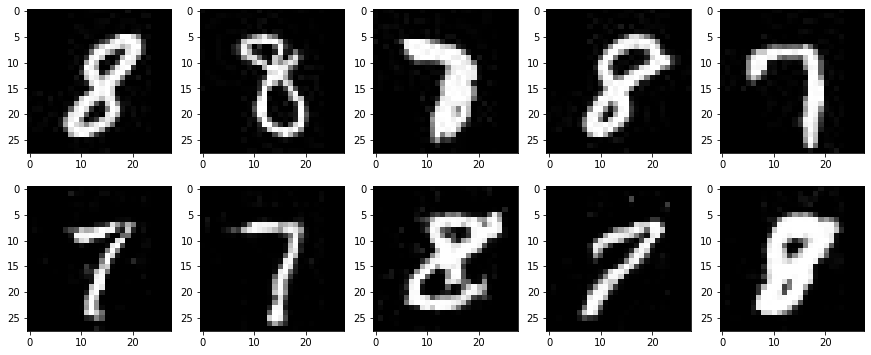

In [25]:
# 生成画像と訓練データを可視化
device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

batch_size=8
z_dim=20
fixed_z=torch.randn(batch_size,z_dim)
fake_images=G_update(fixed_z.to(device))

batch_iterator=iter(train_dataloader)
imges=next(batch_iterator)

# 出力
fig=plt.figure(figsize=(15,6))
for i in range(0,5):
    # 上段に訓練データ
    plt.subplot(2,5,i+1)
    plt.imshow(imges[i][0].cpu().detach().numpy(),'gray')
    
    # 下段に生成データ
    plt.subplot(2,5,5+i+1)
    plt.imshow(fake_images[i][0].cpu().detach().numpy(),'gray')

## テスト画像で異常検知する

In [27]:
# テスト用のDataLoaderの作成

def make_test_datapath_list():
    
    train_img_list=list()
    
    for img_idx in range(5):
        img_path="./data/test_28size/img_7_"+str(img_idx)+'.jpg'
        train_img_list.append(img_path)
        
        img_path="./data/test_28size/img_8_"+str(img_idx)+'.jpg'
        train_img_list.append(img_path)
        
        img_path="./data/test_28size/img_2_"+str(img_idx)+'.jpg'
        train_img_list.append(img_path)
        
    return train_img_list

test_img_list=make_test_datapath_list()

mean=(0.5,)
std=(0.5,)
test_dataset=GAN_Img_Dataset(file_list=test_img_list,transform=ImageTransform(mean,std))

batch_size=5

test_dataloader=torch.utils.data.DataLoader(test_dataset,batch_size=batch_size,shuffle=False)

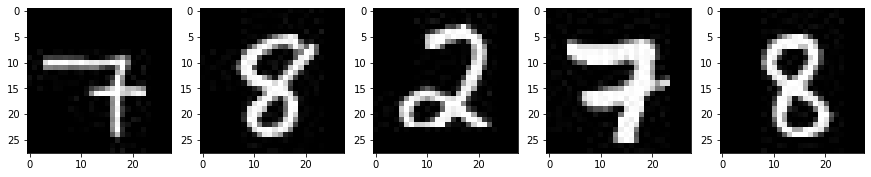

In [28]:
# check
batch_iterator=iter(test_dataloader)
imges=next(batch_iterator)

fig=plt.figure(figsize=(15,6))
for i in range(0,5):
    plt.subplot(2,5,i+1)
    plt.imshow(imges[i][0].cpu().detach().numpy(),'gray')

In [29]:
def Anomaly_score(x,fake_img,z_out_real,D,Lambda=0.1):
    
    residual_loss=torch.abs(x-fake_img)
    residual_loss=residual_loss.view(residual_loss.size()[0],-1)
    residual_loss=torch.sum(residual_loss,dim=1)
    
    _,x_feature=D(x,z_out_real)
    _,G_feature=D(fake_img,z_out_real)
    
    discriminator_loss=torch.abs(x_feature-G_feature)
    discriminator_loss=discriminator_loss.view(discriminator_loss.size()[0],-1)
    discriminator_loss=torch.sum(discriminator_loss,dim=1)
    
    loss_each=(1-Lambda)*residual_loss+Lambda*discriminator_loss
    
    total_loss=torch.sum(loss_each)
    
    return total_loss,loss_each,residual_loss

total loss :  [180. 250. 301. 199. 167.]


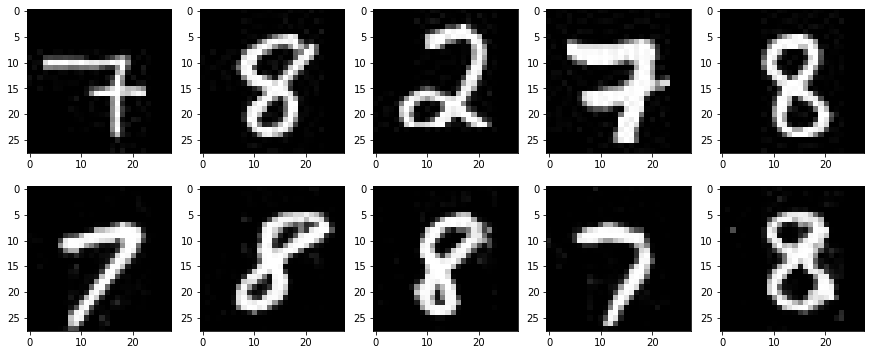

In [30]:
# 異常検知したい画像
x=imges[0:5]
x=x.to(device)

# 教師データの画像をエンコードしてzにしてからGで生成
z_out_real=E_update(imges.to(device))
imges_reconstract=G_update(z_out_real)

# calc losses
loss,loss_each,residual_loss_each=Anomaly_score(x,imges_reconstract,z_out_real,D_update,Lambda=0.1)
loss_each=loss_each.cpu().detach().numpy()
print("total loss : ",np.round(loss_each,0))

# visualization
fig=plt.figure(figsize=(15,6))
for i in range(0,5):
    # 上段に訓練データ
    plt.subplot(2,5,i+1)
    plt.imshow(imges[i][0].cpu().detach().numpy(),'gray')
    
    # 下段に生成データ
    plt.subplot(2,5,5+i+1)
    plt.imshow(imges_reconstract[i][0].cpu().detach().numpy(),'gray')